# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1RDBpKssJ7wE_PlYPwm42IDGAbue_sPl9/view?usp=sharing

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import os

os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data')


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [0]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 88154022.81it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

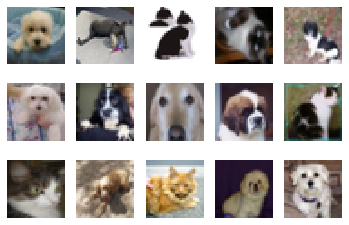

In [0]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [0]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

"""
Training has 8000 images, testing has 2000 images, and validation has 2000 
images for a total of 12,000 images
"""


8000
2000
2000


'\nTraining has 8000 images, testing has 2000 images, and validation has 2000 \nimages for a total of 12,000 images\n'

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [0]:
"""
If we only use the training set to model the AI, we would get a situation where
the AI would obtain a 100% accuracy and over fit the training set; the AI 
would only be able to understand the pictures within the training set, and 
every other image of dog or cat would result in poor accuracy. That is why 
we should use the validation set to validate our results.
"""

'\nIf we only use the training set to model the AI, we would get a situation where\nthe AI would obtain a 100% accuracy and over fit the training set; the AI \nwould only be able to understand the pictures within the training set, and \nevery other image of dog or cat would result in poor accuracy. That is why \nwe should use the validation set to validate our results.\n'

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [0]:
for param in small_net.parameters():
    print(param.shape)
print("\n")
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
"""
batch_size=64, learning_rate=0.01, num_epochs=30
"""

'\nbatch_size=64, learning_rate=0.01, num_epochs=30\n'

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [0]:
small_net = SmallNet()
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/5epochs')
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=5)

"""
Epoch 1: Train err: 0.439375, Train loss: 0.6837765421867371 |
Validation err: 0.3915, Validation loss: 0.6662272289395332
contains the epoch iteration, training error, train loss, 
validation error, and validation loss
"""

0it [00:00, ?it/s]

170500096it [00:04, 41054577.54it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.439375, Train loss: 0.6837765421867371 |Validation err: 0.3915, Validation loss: 0.6662272289395332
Epoch 2: Train err: 0.380875, Train loss: 0.6527453322410584 |Validation err: 0.3935, Validation loss: 0.6626366525888443
Epoch 3: Train err: 0.342125, Train loss: 0.625328052520752 |Validation err: 0.3335, Validation loss: 0.6186922714114189
Epoch 4: Train err: 0.323875, Train loss: 0.6055600070953369 |Validation err: 0.339, Validation loss: 0.6171749532222748
Epoch 5: Train err: 0.314625, Train loss: 0.5930321733951569 |Validation err: 0.3215, Validation loss: 0.6096237320452929
Finished Training
Total time elapsed: 15.90 seconds


'\n\n'

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [0]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
small_net = SmallNet()
large_net = LargeNet()
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/Default Small')
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/Default Large')
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716759681702 |Validation err: 0.3865, Validation loss: 0.6602997574955225
Epoch 2: Train err: 0.37325, Train loss: 0.649762942314148 |Validation err: 0.3845, Validation loss: 0.657599113881588
Epoch 3: Train err: 0.360125, Train loss: 0.6388907418251037 |Validation err: 0.3485, Validation loss: 0.629109650850296
Epoch 4: Train err: 0.346125, Train loss: 0.6246512727737427 |Validation err: 0.3555, Validation loss: 0.6221790071576834
Epoch 5: Train err: 0.3345, Train loss: 0.6153933835029602 |Validation err: 0.328, Validation loss: 0.6188624110072851
Epoch 6: Train err: 0.3175, Train loss: 0.6037003107070923 |Validation err: 0.339, Validation loss: 0.6092050103470683
Epoch 7: Train err: 0.315875, Train loss: 0.5944590408802033 |Validation err: 0.329, Validation loss: 0.597393348813057
Epoch 8: Train err: 0.308, Train loss: 0.5828994708061218 |Validation err: 0.3075,

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

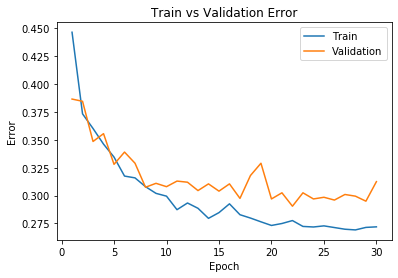

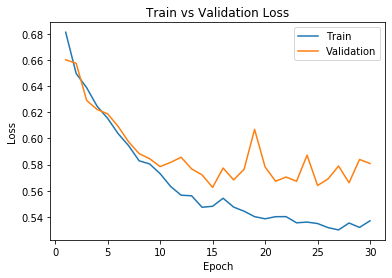

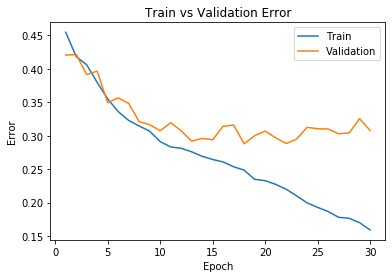

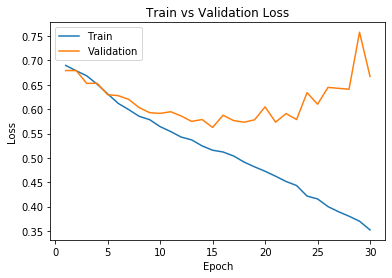

In [0]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/Default Small')
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/Default Large')
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/Default Small/' + small_model_path)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/Default Large/' + large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [0]:
"""
For all 4 graphs, the error and loss for the training set always decreases
For the validation set in the small net graphs, the error and loss
 also decreases and then eventually plateaus. 
For the validation set in the large net graphs, the error and loss
initiall decrease, but overfitting seems to occur. The loss 
rapidly grows and the error also grows slightly which is a classic
symptom of overfitting
"""

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.51625, Train loss: 0.6936100363731384 |Validation err: 0.516, Validation loss: 0.6934121195226908
Epoch 2: Train err: 0.509125, Train loss: 0.6931850962638855 |Validation err: 0.4955, Validation loss: 0.6930262967944145
Epoch 3: Train err: 0.47725, Train loss: 0.6928228349685669 |Validation err: 0.4655, Validation loss: 0.6927765384316444
Epoch 4: Train err: 0.475125, Train loss: 0.6924723448753357 |Validation err: 0.457, Validation loss: 0.692213948816061
Epoch 5: Train err: 0.45925, Train loss: 0.6920594296455383 |Validation err: 0.4445, Validation loss: 0.6919835191220045
Epoch 6: Train err: 0.456875, Train loss: 0.6916070194244385 |Validation err: 0.4415, Validation loss: 0.6913337782025337
Epoch 7: Train err: 0.45175, Train loss: 0.6911009168624878 |Validation err: 0.437, Validation loss: 0.6908031366765499
Epoch 8: Train err: 0.448625, Train loss: 0.6904502320289612 |Validation err: 

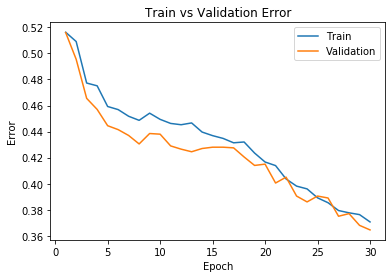

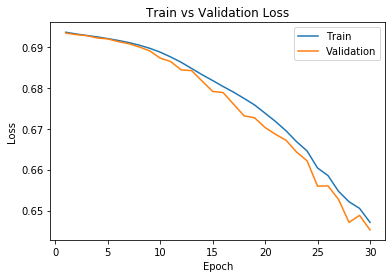

'\nThe total time elapsed with the default parameters was 115 s\nWith the new value of learning rate it was 112 s \nresulting in a slower time by 3 s\nbut the difference is quite insignificant\n'

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/lr=0.001')
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/lr=0.001/' + large_model_path)

"""
The total time elapsed with the default parameters was 110.79 s
With the new value of learning rate it was 112.26 s 
resulting in a slower time by 1.47 s
but the difference is quite insignificant

by reducing the learning rate, we avoided overfitting since 
the graph's error and loss keeps reducing, but the validation error and loss 
never plateaus thus showing that not all the weights are optimal, so more 
epochs are required (underfitting)
"""

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

0it [00:00, ?it/s]

170500096it [00:04, 42069155.11it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Vali

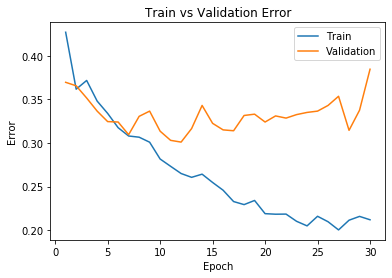

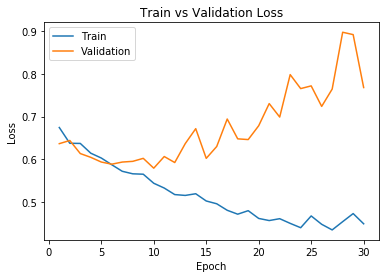

In [0]:
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/lr=0.1')
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/lr=0.1/' + large_model_path)

"""
The total time elapsed with the default parameters was 110.79 s
With the new value of learning rate it was 112.85 s 
resulting in a slower time by 2.06 s
similar to when lr = 0.001

by increasing the learning rate, we significantly overfitted the data
much greater than the default parameters since the graph's validation
 error and loss keeps increasing after an initial decrease
"""

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

0it [00:00, ?it/s]

170500096it [00:04, 39584399.87it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation 

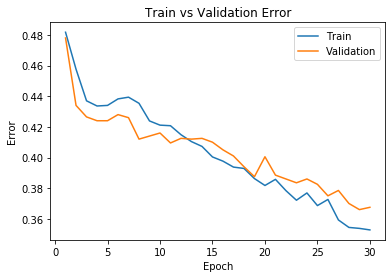

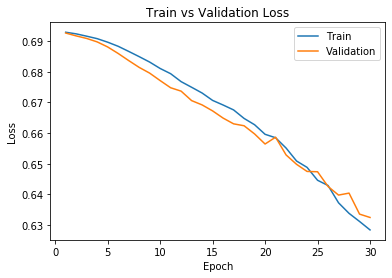

In [0]:
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=512')
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=512/' + large_model_path)

"""
The total time elapsed with the default parameters was 110.79 s
With the new value of learning rate it was 96.39 s 
resulting in a much faster time by 14.40 s
since the batch size is much larger

by increasing the batch size rate, we are reducing the amount of tests
significantly since the number of epochs are the same. Therefore we are
prematurely completing the tests. That is why the graphs validation 
error and loss is always decreasing throughout the whole graph (underfitting)
"""

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

0it [00:00, ?it/s]

170500096it [00:03, 43525555.82it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Vali

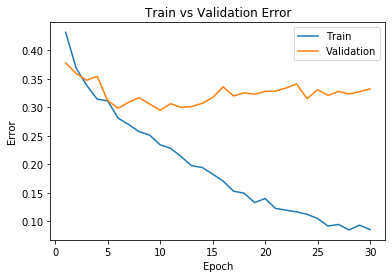

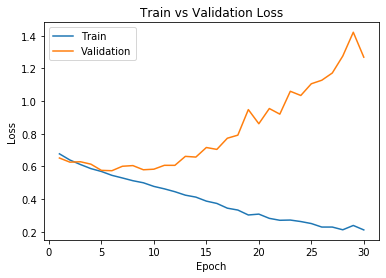

In [0]:
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=16')
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=16/' + large_model_path)

"""
The total time elapsed with the default parameters was 110.79 s
With the new value of learning rate it was 160.43 s 
resulting in a much much slower time by 49.64 s
since the batch size is much smaller

by decreasing the batch size rate, we are increasing the amount of tests
significantly since the number of epochs are the same. Therefore we are
testing too many times which resulted in overfitting the test data. 
That is why the graphs validation error and loss is instantly increasing
throughout the whole graph.
"""

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [0]:
"""
batch_size=32, learning_rate=0.005, num_epochs=30
"""

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48225, Train loss: 0.692178237438202 |Validation err: 0.4475, Validation loss: 0.6885521686266339
Epoch 2: Train err: 0.442125, Train loss: 0.6845396947860718 |Validation err: 0.4185, Validation loss: 0.6846858026489379
Epoch 3: Train err: 0.40775, Train loss: 0.6715821731090545 |Validation err: 0.384, Validation loss: 0.6544774515288216
Epoch 4: Train err: 0.383, Train loss: 0.6557607760429383 |Validation err: 0.413, Validation loss: 0.6593729011596196
Epoch 5: Train err: 0.365, Train loss: 0.6380288276672363 |Validation err: 0.341, Validation loss: 0.6287506676855541
Epoch 6: Train err: 0.3505, Train loss: 0.6246151375770569 |Validation err: 0.363, Validation loss: 0.6382630618791731
Epoch 7: Train err: 0.343875, Train loss: 0.6158546090126038 |Validation err: 0.333, Validation loss: 0.6138265194400908
Epoch 8: Train err: 0.327375, Train loss: 0.600860352396965 |Validation err: 0.336, Va

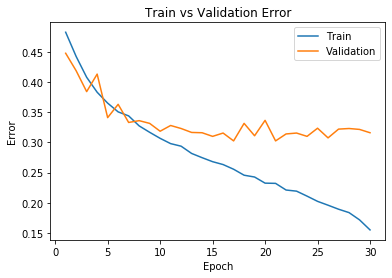

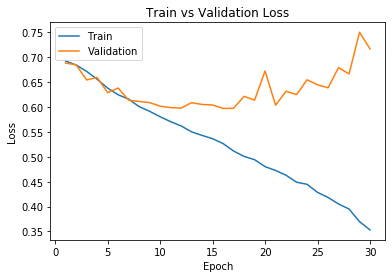

In [0]:
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=32lr=0.005')
large_net = LargeNet()
train_net(large_net, batch_size=32, learning_rate=0.005, num_epochs=30)
large_model_path = get_model_name("large", batch_size=32, learning_rate=0.005, epoch=29)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=32lr=0.005/' + large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [0]:
"""
batch_size=32, learning_rate=0.003, epoch=20

The error for validation plateaus but the loss increases heavily which is a 
result of overfitting, thus I decided to reduce the number of epochs. Moreover,
since last test, the lr = 0.005 caused validation loss to increase, I decided to
decrease lr so less epochs are more effective. 
"""

'\nbatch_size=32, learning_rate=0.003, epoch=19\n\nThe error for validation plateaus but the loss increases heavily which is a \nresult of overfitting, thus I decided to reduce the number of epochs. Moreover,\nsince last test, the lr = 0.005 caused validation loss to increase, I decided to\ndecrease lr so less epochs are more effective. \n'

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.480875, Train loss: 0.6915083553791046 |Validation err: 0.4205, Validation loss: 0.68625641626025
Epoch 2: Train err: 0.44025, Train loss: 0.6842017025947571 |Validation err: 0.414, Validation loss: 0.680083936169034
Epoch 3: Train err: 0.421375, Train loss: 0.6766518726348877 |Validation err: 0.391, Validation loss: 0.6660251607970585
Epoch 4: Train err: 0.395875, Train loss: 0.6665743548870087 |Validation err: 0.413, Validation loss: 0.6648541688919067
Epoch 5: Train err: 0.3775, Train loss: 0.6561251010894775 |Validation err: 0.3745, Validation loss: 0.6467017928759257
Epoch 6: Train err: 0.36525, Train loss: 0.6428999528884888 |Validation err: 0.378, Validation loss: 0.6460201229367938
Epoch 7: Train err: 0.356, Train loss: 0.634364688873291 |Validation err: 0.3515, Validation loss: 0.6271201665439303
Epoch 8: Train err: 0.350375, Train loss: 0.6203421868085861 |Validation err: 0.3495,

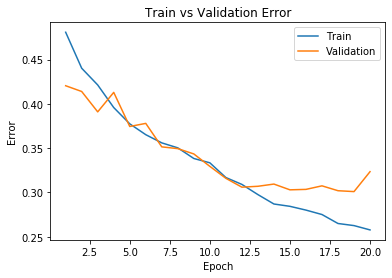

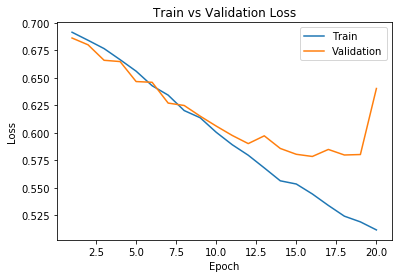

In [0]:
os.chdir('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=32lr=0.003ep=20')
large_net = LargeNet()
train_net(large_net, batch_size=32, learning_rate=0.003, num_epochs=20)
large_model_path = get_model_name("large", batch_size=32, learning_rate=0.003, epoch=19)
plot_training_curve('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=32lr=0.003ep=20/' + large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
net = LargeNet()
model_path = get_model_name("large", batch_size=32, learning_rate=0.003, epoch=18)
state = torch.load('/content/drive/My Drive/3rd year/aps360/Colab Notebooks/lab2/lab2data/batch=32lr=0.003ep=20/' + model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [0]:
state

OrderedDict([('conv1.weight',
              tensor([[[[-0.2490, -0.0899, -0.0806, -0.2092, -0.2538],
                        [ 0.0456,  0.1884,  0.2447,  0.0282,  0.0050],
                        [ 0.0712,  0.1018,  0.0953,  0.2499,  0.0332],
                        [ 0.1198,  0.0481,  0.2365,  0.0754,  0.2536],
                        [ 0.1352, -0.0321,  0.0917,  0.0955,  0.1132]],
              
                       [[-0.1559, -0.0581, -0.0374, -0.2147, -0.1215],
                        [-0.0158,  0.0514,  0.1256,  0.0821, -0.1303],
                        [ 0.0374,  0.1309,  0.1815,  0.1850,  0.1102],
                        [ 0.0523,  0.0920,  0.0286,  0.0399,  0.1262],
                        [ 0.0740, -0.0893, -0.0131, -0.1451,  0.0532]],
              
                       [[-0.0824, -0.0567, -0.0316, -0.0334, -0.1722],
                        [ 0.1036,  0.1018,  0.0823,  0.1814, -0.0916],
                        [-0.0212,  0.0486,  0.1794,  0.1360,  0.1716],
               

### Part (b) - 2pt

Justify your choice of model from part (a).

In [0]:
"""
I used the epoch value of 18 as in the graph, the minimum loss and error for 
validation was around when the epoch value was 18. For all the tests done
for this lab, the hyperparameters for this test gave out the minimum error and 
validation for all tests
"""

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [0]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size = 32)

criterion = nn.BCEWithLogitsLoss()
validation_err = evaluate(large_net, val_loader, criterion)
training_err = evaluate(large_net, train_loader, criterion)
testing_err = evaluate(large_net, test_loader, criterion)
print(validation_err)
print(training_err)
print(testing_err)

Files already downloaded and verified
Files already downloaded and verified
(0.3235, 0.6372715513857584)
(0.282, 0.5384061478376388)
(0.33, 0.6231571194671449)


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [0]:
"""
the hyperparameters are adjusted to imrove the error of the validation set
meanwhile, the testing set has no hyperparameters or weights adjusted for this
set. Thus, the error for the testing set will have the greatest error
"""

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [0]:
"""
when we test the testing set, the weights and hyperparameters would be adjusted
for the test set. Therefore it can cause biased weights and hyperparameters for
the testing set, even thought the testing set is supposed to be unbiased. 
Therefore, using this data at the end is the best method since it would test 
real life sitatuation where the AI has never seen a specific situation outside 
the training/validation set. You can measure how accurate you were able to 
get the AI to get. 
"""

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import os

###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(32 * 32 * 3, 280)
        self.layer2 = nn.Linear(280, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32 * 3)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2

def eval(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def AI (batch, learning_rate, num_epochs):
  pigeon = Pigeon()
  torch.manual_seed(1000) # set the random seed

  # load the data
  train_loader, val_loader, test_loader, classes = get_data_loader(
      target_classes=["cat", "dog"], 
      batch_size = batch)
  
  # simplified training code to train `pigeon` on the "small digit recognition" task
  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(pigeon.parameters(), lr=learning_rate, momentum=0.9)
  train_err = np.zeros(num_epochs)
  train_loss = np.zeros(num_epochs)
  val_err = np.zeros(num_epochs)
  val_loss = np.zeros(num_epochs)

  start_time = time.time()
  for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_train_err = 0.0
    total_epoch = 0
    
    
    for i, data in enumerate(train_loader, 0):
      # Get the inputs
      inputs, labels = data
      labels = normalize_label(labels) # Convert labels to 0/1
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward pass, backward pass, and optimize
      outputs = pigeon(inputs)
      outputs = outputs.squeeze()
      loss = criterion(outputs, labels.float())
      loss.backward()
      optimizer.step()
      corr = (outputs > 0.0).squeeze().long() != labels
      total_train_err += int(corr.sum())
      total_train_loss += loss.item()
      total_epoch += len(labels)
    train_err[epoch] = float(total_train_err) / total_epoch
    train_loss[epoch] = float(total_train_loss) / (i+1)
    val_err[epoch], val_loss[epoch] = eval(pigeon, val_loader, criterion)
    print(("Epoch {}: Train err: {}, Train loss: {} |"+
              "Validation err: {}, Validation loss: {}").format(
                  epoch + 1,
                  train_err[epoch],
                  train_loss[epoch],
                  val_err[epoch],
                  val_loss[epoch]))
  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("time take", elapsed_time)


  validation_err = eval(pigeon, val_loader, criterion)
  training_err = eval(pigeon, train_loader, criterion)
  testing_err = eval(pigeon, test_loader, criterion)
  print('validation error: ', validation_err)
  print('training error: ', training_err)
  print('testing error: ', testing_err)

In [0]:
"""
batch_size=32, learning_rate=0.003, epoch=18
"""
lr = [0.003, 0.01, 0.1, 0.001]
batch = [32, 64, 64, 512]
epoch = [18, 30, 30, 30]
for i in range(len(lr)):
  print("testing these values: ", lr[i], batch[i], epoch[i])
  AI(batch[i], lr[i], epoch[i])

"""
These are the initial values i started with. 
lr = [0.003, 0.01, 0.1, 0.001]
batch = [32, 64, 64, 1, 512]
epoch = [18, 30, 30, 30]

First Test
validation error:  (0.365, 0.7934664591910348)
training error:  (0.090875, 0.26226053074002265)
testing error:  (0.341, 0.7537538205820417)

Second Test
validation error:  (0.359, 1.3801594991236925)
training error:  (0.04425, 0.13330753320455552)
testing error:  (0.371, 1.3198279812932014)

Third Test
validation error:  (0.46, 57.188344061374664)
training error:  (0.39575, 34.02498516082764)
testing error:  (0.426, 53.88509452342987)

Fourth Test
validation error:  (0.3845, 0.6515187323093414)
training error:  (0.364125, 0.6378198191523552)
testing error:  (0.37, 0.6443434208631516)



Realized that most of these values were overfitting, so I decided to 
change the number of epochs for each case to reduce the validation error
As lr increases, the error in fact increases which makes sense since it is
skipping over the optimal value of the weights where it minimizes error. 
For example, for the first case, the error and loss were their smallest values.
The second test has the lowest error, but their losses are incredibly high. 
The third test has the worst error and the highest loss. 
The last test didnt have any significant differences. 
"""


testing these values:  0.003 32 18
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.406625, Train loss: 0.6614189646244049 |Validation err: 0.377, Validation loss: 0.6477540778735328
Epoch 2: Train err: 0.362875, Train loss: 0.6347282598018646 |Validation err: 0.3915, Validation loss: 0.6528951554071336
Epoch 3: Train err: 0.3455, Train loss: 0.6208226653337479 |Validation err: 0.374, Validation loss: 0.6428474528448922
Epoch 4: Train err: 0.33375, Train loss: 0.6065558627843857 |Validation err: 0.3945, Validation loss: 0.6600371514047895
Epoch 5: Train err: 0.314, Train loss: 0.5930715210437775 |Validation err: 0.3705, Validation loss: 0.6391285326745775
Epoch 6: Train err: 0.29475, Train loss: 0.5699105613231659 |Validation err: 0.388, Validation loss: 0.6776485480959453
Epoch 7: Train err: 0.28725, Train loss: 0.5553616032600402 |Validation err: 0.364, Validation loss: 0.6437108445735205
Epoch 8: Train err: 0.266875, Train loss: 0.535

'\nThese are the initial values i started with. \nlr = [0.003, 0.01, 0.1, 0.001]\nbatch = [32, 64, 64, 1, 512]\nepoch = [18, 30, 30, 30]\n\nFirst Test\nvalidation error:  (0.365, 0.7934664591910348)\ntraining error:  (0.090875, 0.26226053074002265)\ntraining error:  (0.341, 0.7537538205820417)\n\nSecond Test\nvalidation error:  (0.359, 1.3801594991236925)\ntraining error:  (0.04425, 0.13330753320455552)\ntraining error:  (0.371, 1.3198279812932014)\n\nThird Test\nvalidation error:  (0.46, 57.188344061374664)\ntraining error:  (0.39575, 34.02498516082764)\ntraining error:  (0.426, 53.88509452342987)\n\nFourth Test\n'

In [0]:

#updated hyperparameters by taking optimal hyperparameters from each case:
lr = [0.002]
batch = [64]
epoch = [15]
AI(batch[0], lr[0], epoch[0])

"""
(Optimal) ANN:
validation error:  (0.359, 0.6493444442749023)
training error:  (0.25075, 0.5209894547462464)
testing error:  (0.346, 0.6395964529365301)

(Optimal) CNN:
validation error:  (0.3235, 0.6372715513857584)
training error: (0.282, 0.5384061478376388)
testing error:  (0.33, 0.6231571194671449)

Although the validation is higher than some previous test cases, 
the testing error is one of the smallest values with the lowest loss. 
This can be more optimized by adjusting the epochs, but since this already
has an accuracy of ~66%, it is pretty good. But this is slightly worse than the
convolution neural network tested above, as it is more accurate by 1.6%. Since 
the epochs were small, the ANN was actually more efficient 
(ANN = 49s, CNN = 91s), but the code was also re-adjusted for the ANN removing
unecessary calculations that may have effected the time. 
Although there is not a large difference in error and the ANN has a larger
calculation time, further optimizing the code would
result in the CNN being more efficient and effective (increasing epochs, 
increasing number of layers, etc).
"""

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.42225, Train loss: 0.6723266024589538 |Validation err: 0.403, Validation loss: 0.6600517332553864
Epoch 2: Train err: 0.38025, Train loss: 0.6502299389839172 |Validation err: 0.388, Validation loss: 0.6530246455222368
Epoch 3: Train err: 0.367125, Train loss: 0.6385505800247192 |Validation err: 0.3805, Validation loss: 0.6470366809517145
Epoch 4: Train err: 0.355625, Train loss: 0.6290501084327698 |Validation err: 0.3865, Validation loss: 0.6525286305695772
Epoch 5: Train err: 0.34475, Train loss: 0.6220973386764527 |Validation err: 0.3765, Validation loss: 0.6435692869126797
Epoch 6: Train err: 0.333625, Train loss: 0.6126908812522888 |Validation err: 0.3765, Validation loss: 0.6430167742073536
Epoch 7: Train err: 0.327, Train loss: 0.6052518436908721 |Validation err: 0.3785, Validation loss: 0.643680278211832
Epoch 8: Train err: 0.318625, Train loss: 0.5959443235397339 |Validation err: 0

'\n(Optimal) ANN:\nvalidation error:  (0.359, 0.6493444442749023)\ntraining error:  (0.25075, 0.5209894547462464)\ntesting error:  (0.346, 0.6395964529365301)\n\n(Optimal) CNN:\nvalidation error:  (0.3235, 0.6372715513857584)\ntraining error: (0.282, 0.5384061478376388)\ntesting error:  (0.33, 0.6231571194671449)\n\nAlthough the validation is higher than some previous test cases, \nthe testing error is one of the smallest values with the lowest loss. \nThis can be more optimized by adjusting the epochs, but since this already\nhas an accuracy of ~66%, it is pretty good. But this is slightly worse than the\nconvolution neural network tested above, as it is more accurate by 1.6%. \nAlthough there is not a large difference, further optimizing the code would\nresult in the CNN being more efficient and effective. \n'